In [21]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
%matplotlib inline


In [22]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [23]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
# volatile = True:  autograd 추적 x    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train() # Dropout, BN o
    if phase == 'validation':
        model.eval() # Dropout, BN x
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        # size_average 는 올드해서 요즘 안씀 ㅋㅋ
        running_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [24]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [25]:
# For Dogs & Cats dataset
train_dset = ImageFolder('C:/Users/HeoJiHae/Desktop/heojihye/Statistics/Poster_presentation/Ensemble/dogsandcats/train/',transform=data_transform)
val_dset = ImageFolder('C:/Users/HeoJiHae/Desktop/heojihye/Statistics/Poster_presentation/Ensemble/dogsandcats/valid/',transform=data_transform)

classes=2

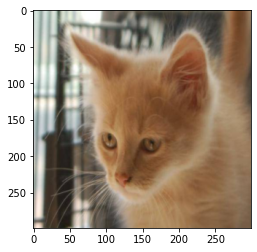

In [26]:
imshow(train_dset[150][0])

## Creating data loader for training and validation datasets

num_workers는 학습 도중 CPU 작업을 몇 개의 코어를 사용해서 진행할지에 대한 설정 파라미터이다.

In [27]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating ResNet 34 model

In [28]:
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.cuda()

In [29]:
m = nn.Sequential(*list(my_resnet.children())[:-1])

## Extracting Convolutional features

In [30]:
#For training data

# Stores the labels of the train data
trn_labels = [] 

# Stores the pre convoluted features of the train data
trn_features = [] 

#Iterate through the train data and store the calculated features and the labels
for d,la in train_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data

#Iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d,la in val_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    # 확장하다.
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## Creating train and validation feature dataset

In [31]:
#Creating dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

#Creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [32]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [33]:
fc_in_size = 8192

In [34]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [35]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and validate the model

In [36]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [20]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.16 and training accuracy is 21909/23000     95.26
validation loss is  0.16 and validation accuracy is 1893/2000     94.65
training loss is  0.15 and training accuracy is 21961/23000     95.48
validation loss is  0.15 and validation accuracy is 1901/2000     95.05
training loss is  0.14 and training accuracy is 22006/23000     95.68
validation loss is  0.15 and validation accuracy is 1909/2000     95.45
training loss is  0.13 and training accuracy is 22051/23000     95.87
validation loss is  0.15 and validation accuracy is 1900/2000      95.0
training loss is  0.13 and training accuracy is 22095/23000     96.07
validation loss is  0.15 and validation accuracy is 1895/2000     94.75
training loss is  0.12 and training accuracy is 22164/23000     96.37
validation loss is  0.14 and validation accuracy is 1899/2000     94.95
training loss is  0.12 and training accuracy is 22181/23000     96.44
validation loss is  0.13 and validation accuracy is 1914/2000      95.7
traini

In [21]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.11 and training accuracy is 22288/23000      96.9
validation loss is  0.12 and validation accuracy is 1923/2000     96.15
training loss is   0.1 and training accuracy is 22301/23000     96.96
validation loss is  0.11 and validation accuracy is 1925/2000     96.25
training loss is   0.1 and training accuracy is 22284/23000     96.89
validation loss is  0.11 and validation accuracy is 1928/2000      96.4
training loss is 0.095 and training accuracy is 22371/23000     97.27
validation loss is  0.11 and validation accuracy is 1927/2000     96.35
training loss is 0.094 and training accuracy is 22363/23000     97.23
validation loss is  0.11 and validation accuracy is 1925/2000     96.25
training loss is  0.09 and training accuracy is 22404/23000     97.41
validation loss is  0.11 and validation accuracy is 1923/2000     96.15
training loss is 0.089 and training accuracy is 22406/23000     97.42
validation loss is   0.1 and validation accuracy is 1926/2000      96.3
traini

In [22]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.082 and training accuracy is 22473/23000     97.71
validation loss is   0.1 and validation accuracy is 1934/2000      96.7
training loss is  0.08 and training accuracy is 22456/23000     97.63
validation loss is  0.12 and validation accuracy is 1917/2000     95.85
training loss is 0.077 and training accuracy is 22507/23000     97.86
validation loss is   0.1 and validation accuracy is 1930/2000      96.5
training loss is 0.075 and training accuracy is 22518/23000      97.9
validation loss is 0.096 and validation accuracy is 1938/2000      96.9
training loss is 0.073 and training accuracy is 22539/23000      98.0
validation loss is   0.1 and validation accuracy is 1936/2000      96.8
training loss is 0.073 and training accuracy is 22542/23000     98.01
validation loss is 0.089 and validation accuracy is 1942/2000      97.1
training loss is 0.071 and training accuracy is 22545/23000     98.02
validation loss is  0.09 and validation accuracy is 1941/2000     97.05
traini